# Семантическая Сегментация. Часть 1.

## Переключение версии TensorFlow

In [1]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
import random  # Модуль для генерации случайных чисел и выборок.
import imageio  # Библиотека для чтения и записи изображений различных форматов.
import numpy as np  # Библиотека для работы с многомерными массивами и математическими операциями.
import matplotlib.pyplot as plt  # Модуль для построения графиков и отображения изображений.
import tensorflow as tf  # Основная библиотека для создания и обучения нейронных сетей.

# Пояснения:

# random — используется, чтобы создавать случайные значения, например, для случайного выбора элементов или инициализации параметров.
# Это важно в задачах обучения моделей для генерации случайных батчей данных или для случайной инициализации весов.

# imageio — помогает загружать изображения из файлов или URL в виде массивов пикселей (обычно numpy-массивов).
# Это удобно, потому что нейронные сети работают с числовыми данными, а не с изображениями напрямую.

# numpy (np) — основная библиотека для работы с массивами и матрицами.
# Изображения в Python обычно хранятся в виде 3D массивов (высота × ширина × количество цветовых каналов).
# np предоставляет удобные функции для обработки и преобразования таких данных.

# matplotlib.pyplot (plt) — используется для визуализации данных, включая изображения.
# Позволяет вывести изображение на экран, построить графики и диаграммы, что важно для анализа данных и результатов моделей.

# tensorflow (tf) — это мощный фреймворк для создания, обучения и запуска нейронных сетей.
# Включает инструменты для работы с данными, построения моделей, оптимизации и оценки качества.
# Позволяет создавать сложные архитектуры и эффективно использовать вычисления на GPU.

# В сумме, эти импорты дают нам все необходимые инструменты для загрузки изображений,
# их обработки и анализа с помощью нейросетей, а также для визуализации результатов.


## Загрузка данных
`me_256.png` - Изображение

`me_gt_256.png` - Карта сагментации (человек/фон)

In [3]:
if 1:
    # if 1 — это всегда True, поэтому этот блок кода всегда выполняется.
    # Используется как простой способ "включить" код.

    !wget https://raw.githubusercontent.com/dkorobchenko-nv/person-segmentation/master/img/me_256.png
    # Команда !wget — это вызов системной команды wget из Jupyter или Colab,
    # которая скачивает файл с указанного URL.
    # Здесь загружается изображение "me_256.png" с GitHub.

    !wget https://raw.githubusercontent.com/dkorobchenko-nv/person-segmentation/master/img/me_gt_256.png
    # Аналогично, скачивается вторая картинка "me_gt_256.png",
    # которая, судя по названию, может быть ground truth (разметкой) для задачи сегментации.

# В обычном Python вне Jupyter или Colab такой синтаксис вызова shell-команд с "!" не работает.
# Здесь это удобно для быстрого скачивания данных прямо в ноутбуке.


--2025-07-11 17:11:12--  https://raw.githubusercontent.com/dkorobchenko-nv/person-segmentation/master/img/me_256.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118993 (116K) [image/png]
Saving to: ‘me_256.png’

me_256.png          100%[===================>] 116.20K  --.-KB/s    in 0.002s  

2025-07-11 17:11:12 (47.1 MB/s) - ‘me_256.png’ saved [118993/118993]

--2025-07-11 17:11:12--  https://raw.githubusercontent.com/dkorobchenko-nv/person-segmentation/master/img/me_gt_256.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2

## Визуализация данных

/tmp/ipython-input-4-3552080838.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread('me_256.png')


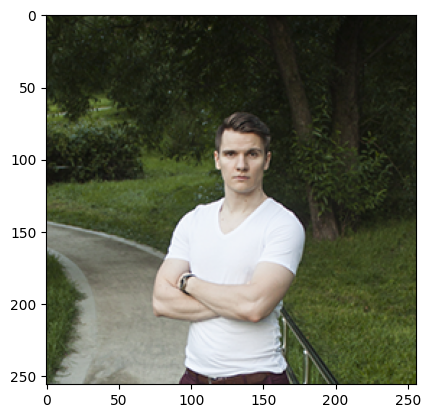

In [4]:
img = imageio.imread('me_256.png')
# Функция imageio.imread загружает изображение из файла 'me_256.png'.
# Результат — numpy-массив с целочисленными значениями пикселей (обычно 0–255) для каждого цветового канала (RGB).

img = img.astype(np.float32) / 255.
# Здесь происходит преобразование типа массива:
# .astype(np.float32) — переводит данные из целых чисел (int) в числа с плавающей точкой (float32),
# что необходимо для математических операций в нейросетях.
# Деление на 255. нормализует значения пикселей из диапазона [0, 255] в диапазон [0.0, 1.0].
# Такая нормализация часто нужна, чтобы улучшить обучение и стабильность модели.

_ = plt.imshow(img)
# plt.imshow отображает изображение, переданное в виде массива numpy.
# Знак "_" перед присваиванием означает, что мы не сохраняем возвращаемое значение функции в переменную,
# это просто визуализация изображения.


/tmp/ipython-input-5-2116848704.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  gt = imageio.imread('me_gt_256.png')


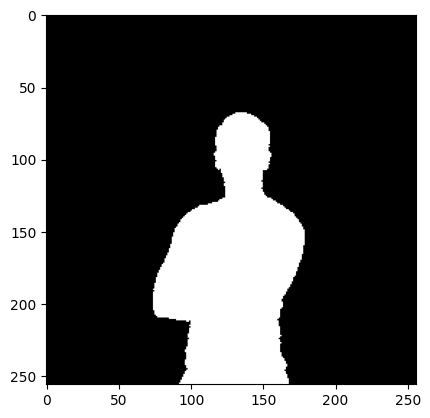

In [5]:
gt = imageio.imread('me_gt_256.png')
# Загружаем изображение с разметкой (ground truth) из файла 'me_gt_256.png'.
# Обычно это цветное изображение с пикселями в диапазоне 0-255.

gt = gt.astype(np.float32) / 255.
# Преобразуем значения пикселей из целочисленных в числа с плавающей точкой (float32),
# затем нормализуем в диапазон [0.0, 1.0], что удобно для дальнейшей обработки.

gt = np.mean(gt, axis=2)[..., None]
# np.mean по оси 2 усредняет значения по каналам цвета (например, по R, G, B),
# таким образом превращая цветное изображение в однотонное (градации серого).
# [..., None] добавляет дополнительную ось в конце массива,
# чтобы сохранить трехмерную структуру (высота × ширина × 1 канал),
# что нужно для совместимости с моделями и функциями, ожидающими 3D вход.

_ = plt.imshow(gt[..., 0], cmap='gray')
# Отображаем первое (и единственное) "цветовое" измерение изображения с разметкой.
# cmap='gray' задает отображение в оттенках серого.


## Создание "игрушечного" сегментационного датасета
Датасет очень маленький, модель скорее всего переобучится.
Наша цель - проверить работоспособность пайплайна.

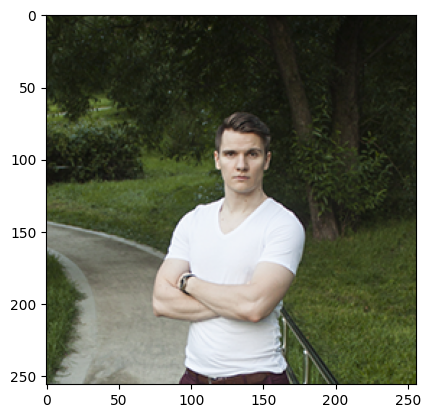

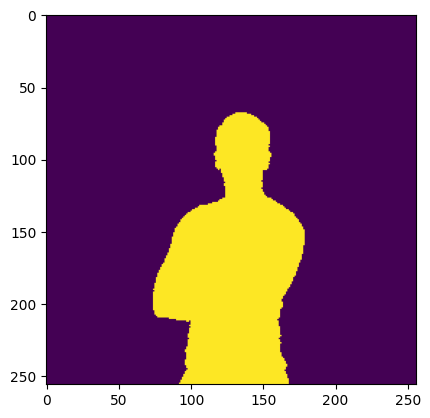

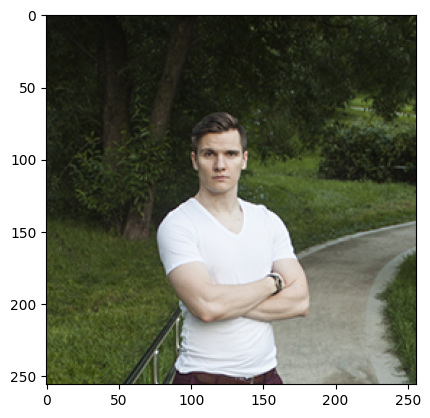

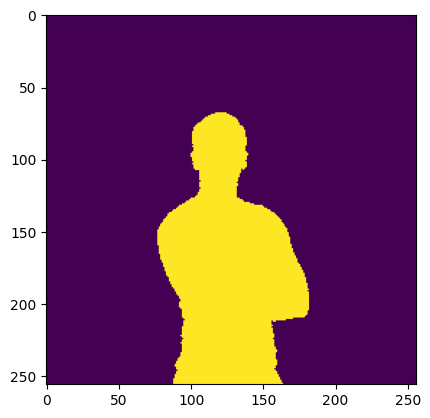

(<matplotlib.image.AxesImage at 0x7ebfb7ba8a10>, None)

In [6]:
train_x = np.stack((img, img[:, ::-1, :]))
# np.stack объединяет два массива вдоль новой оси (формирует батч из 2 изображений).
# img — оригинальное изображение.
# img[:, ::-1, :] — изображение, отражённое по горизонтали (flip по ширине).
# Так создаётся пара изображений для аугментации данных (увеличение объема данных за счёт зеркального отражения).

train_y = np.stack((gt, gt[:, ::-1, :]))
# Аналогично для масок разметки (ground truth).
# Маска отражается так же, чтобы сохранить соответствие с отражённым изображением.

plt.imshow(train_x[0]), plt.show()
# Отображаем первое изображение из батча — оригинал.

plt.imshow(train_y[0][..., 0]), plt.show()
# Отображаем первую маску из батча — оригинал.
# gt имеет размерность (высота, ширина, 1), поэтому выбираем последний канал [..., 0].

plt.imshow(train_x[1]), plt.show()
# Отображаем второе изображение — зеркально отражённое.

plt.imshow(train_y[1][..., 0]), plt.show()
# Отображаем вторую маску — отражённую маску разметки.


## Создание модели U-Net

In [9]:
def build_model():
    x = tf.keras.layers.Input((256, 256, 3))
    # Создаём входной слой, который принимает изображение размером 256x256 пикселей с 3 каналами цвета (RGB).

    # Первый блок свёрточных слоёв
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    # Conv2D — свёрточный слой с 64 фильтрами размером 3x3, padding='same' сохраняет размер входа,
    # activation='relu' — функция активации ReLU для нелинейности.
    out1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    # Ещё один свёрточный слой с теми же параметрами, усиливающий извлечение признаков.
    out = tf.keras.layers.MaxPool2D((2, 2))(out1)
    # MaxPool2D — слой подвыборки, который уменьшает размер изображения в 2 раза (256x256 → 128x128),
    # берёт максимум в каждом окне 2x2, чтобы выделить главные признаки и снизить размерность.

    # Второй блок свёрток
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    # Свёртка 64 фильтрами 3x3, активация ReLU, сохраняет размер благодаря padding='same'.
    out2 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    # Увеличиваем число фильтров до 128 — сеть учится находить более сложные признаки.
    out = tf.keras.layers.MaxPool2D((2, 2))(out2)
    # Снова уменьшаем размер вдвое (128x128 → 64x64).

    # Третий блок
    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    # Свёрточный слой с 256 фильтрами.
    out3 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    # Повтор свёртки с тем же количеством фильтров.
    out = tf.keras.layers.MaxPool2D((2, 2))(out3)
    # Подвыборка, уменьшающая размер до 32x32.

    # Четвёртый блок
    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    # Свёртка с 512 фильтрами для извлечения ещё более сложных признаков.
    out4 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    # Повтор свёртки с 512 фильтрами.
    out = tf.keras.layers.MaxPool2D((2, 2))(out4)
    # Уменьшение размерности до 16x16.

    # Нижний уровень (бутылочное горлышко сети)
    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)
    # Очень глубокий слой с 1024 фильтрами для захвата максимально сложных признаков.
    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)
    # Повтор свёртки с теми же параметрами.

    # Восходящая часть — апсемплинг (обратное уменьшение размера) и объединение с пропущенными связями
    out = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    # Conv2DTranspose — слой обратной свёртки (деформа свёртка) с 512 фильтрами,
    # strides=(2,2) означает увеличение размера в 2 раза (16x16 → 32x32).
    out = tf.keras.layers.Concatenate(axis=3)([out4, out])
    # Объединение (конкатенация) по оси каналов (3-я ось) текущего слоя и сохранённого на нисходящем пути out4,
    # чтобы сохранить пространственную информацию и детали.

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    # Два свёрточных слоя для обработки объединённых признаков.

    out = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    # Увеличение размера до 64x64.
    out = tf.keras.layers.Concatenate(axis=3)([out3, out])
    # Конкатенация с сохранённым слоем out3.
    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    # Два свёрточных слоя.

    out = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    # Размер увеличивается до 128x128.
    out = tf.keras.layers.Concatenate(axis=3)([out2, out])
    # Конкатенация с out2.
    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    # Увеличение размера до исходных 256x256.
    out = tf.keras.layers.Concatenate(axis=3)([out1, out])
    # Конкатенация с out1.
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(out)
    # Последний слой свёртки с 1 фильтром (выходная маска сегментации),
    # activation='sigmoid' даёт значения от 0 до 1 — вероятность принадлежности пикселя к объекту.

    return tf.keras.Model(inputs=x, outputs=out)
    # Возвращаем объект модели с указанными входами и выходами.

model = build_model()
# Создаём модель, вызывая функцию.


## Визуализация U-Net

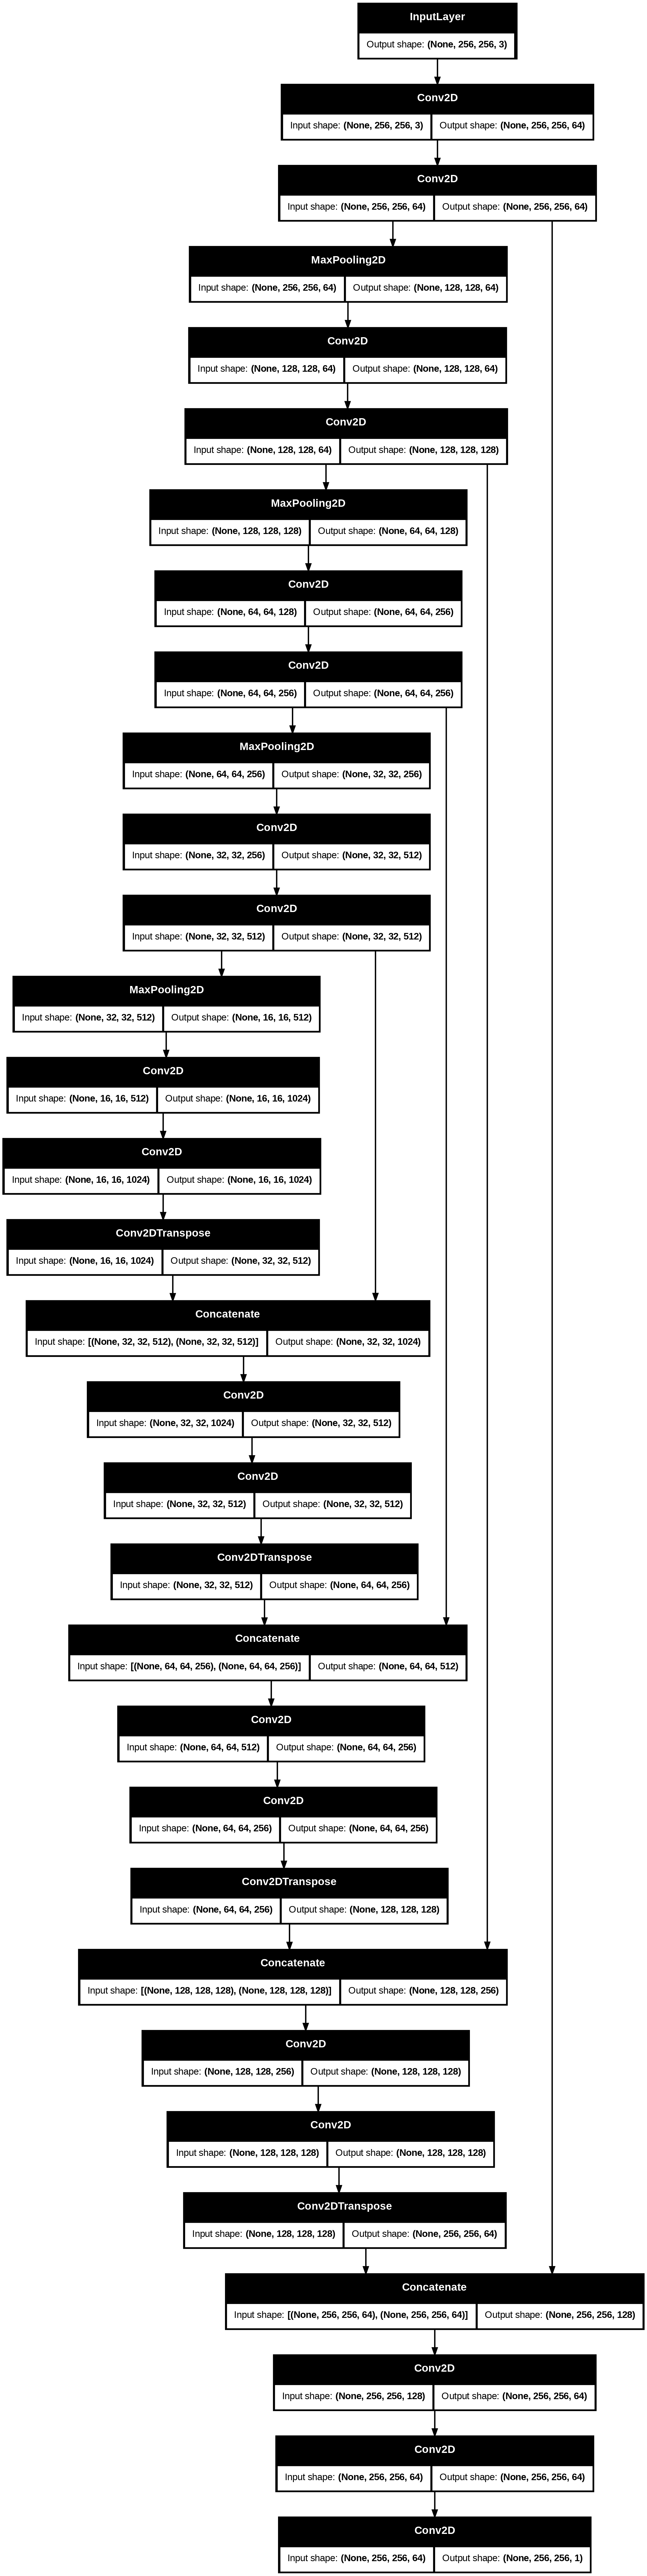

In [10]:
tf.keras.utils.plot_model(model, show_shapes=True)
# Эта функция визуализирует архитектуру модели Keras в виде схемы графа.
# Параметр show_shapes=True отображает размерность (форму) тензоров на каждом слое.
# Это помогает понять, как меняются размеры данных по мере прохождения через сеть.
# В результате вы получите картинку с блоками (слоями) и стрелками, показывающими поток данных.


## Обучение модели

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 27s 164ms/step - loss: 0.6903
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - loss: 0.6687
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.5967
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.9145
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.4532
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.6408
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.6434
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.6144
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.6229
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.5998
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.5661
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.5189
Epoch 13/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.4509
Epoch 14/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.3226
Epoch 15/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.2268
Ep

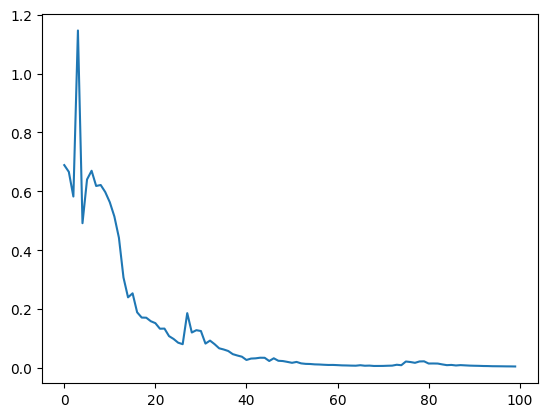

In [11]:
NUM_EPOCHS = 100
# Количество эпох — сколько раз модель пройдет по всему тренировочному набору данных.

BATCH_SIZE = 1
# Размер батча — сколько примеров обрабатывается одновременно перед обновлением весов модели.
# В данном случае по одному изображению за шаг.

loss = tf.keras.losses.BinaryCrossentropy()
# Функция потерь — Binary Crossentropy подходит для бинарной классификации.
# Она измеряет расхождение между предсказанными вероятностями (от 0 до 1) и истинными метками (0 или 1) по каждому пикселю.

model.compile(optimizer='adam', loss=loss)
# Компиляция модели:
# - optimizer='adam' — оптимизатор Adam, который автоматически подбирает шаги обновления весов.
# - loss=loss — используемая функция потерь.

hist = model.fit(train_x, train_y, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS)
# Запускаем обучение модели на данных train_x (входы) и train_y (цели).
# batch_size=1 — обновление параметров после каждого примера.
# epochs=100 — полный проход по всем данным 100 раз.
# Возвращается объект hist, содержащий историю обучения (например, значения loss на каждой эпохе).

plt.plot(hist.history['loss'])
# Строим график функции потерь по эпохам, чтобы видеть, как модель учится и улучшается.


## Пример результата сегментации

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


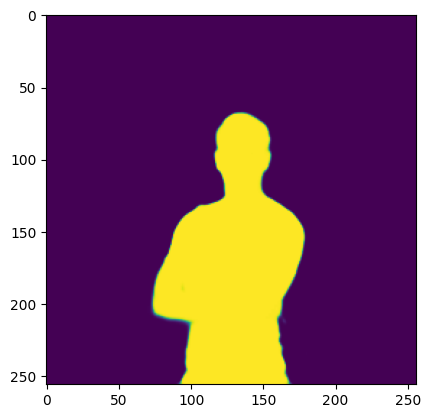

In [12]:
out = model.predict(img[None, ...])[0, ...]
# model.predict делает предсказание на входных данных.
# img[None, ...] добавляет новую ось в начало, превращая изображение из формы (256, 256, 3) в (1, 256, 256, 3),
# т.е. создаёт батч из одного изображения, что требуется для модели.
# [0, ...] извлекает предсказание для первого (и единственного) изображения из батча,
# возвращая массив формы (256, 256, 1) — маску сегментации.

_ = plt.imshow(out[..., 0])
# Отображаем полученную маску сегментации.
# out[..., 0] выбирает единственный канал (вероятность принадлежности пикселя к объекту),
# показывая градации серого от 0 (фон) до 1 (объект).


## Наложение карты сегментации на изображение

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


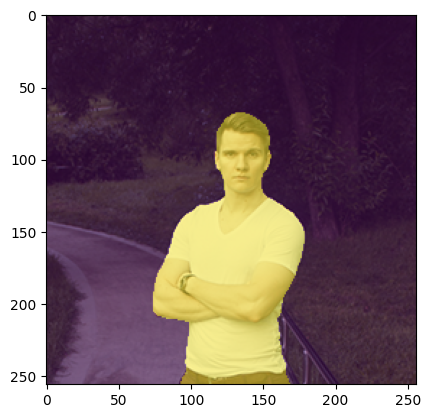

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


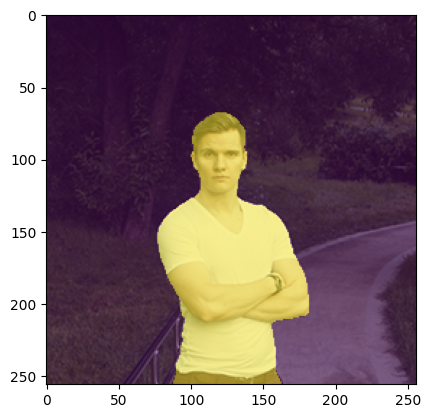

In [13]:
for sample in train_x:
    out = model.predict(sample[None, ...])
    # Для каждого изображения sample из train_x делаем предсказание.
    # sample[None, ...] добавляет размер батча (1), чтобы модель приняла вход.
    # out — предсказание формы (1, 256, 256, 1).

    seg_map = (out[0, ..., 0] > 0.5).astype(np.float32)
    # Превращаем вероятностную маску в бинарную: пиксели с вероятностью > 0.5 считаются "объектом".
    # out[0, ..., 0] — убираем батч и канал, получая двумерную маску.
    # .astype(np.float32) переводит булевы значения (True/False) в 1.0/0.0.

    seg_map_clr = plt.get_cmap('viridis')(seg_map)[..., :3]
    # Применяем цветовую карту 'viridis' для визуализации маски.
    # Результат — цветное изображение (256x256x3), где 1 в маске становится ярким цветом,
    # а 0 — прозрачным или тёмным.
    # [:, :, :3] — берем только RGB (без альфа-канала).

    plt.imshow(sample * 0.5 + seg_map_clr * 0.5)
    # Накладываем цветную маску поверх исходного изображения с прозрачностью 50%,
    # чтобы видеть одновременно и исходное фото, и сегментацию.

    plt.show()
    # Показываем результат для каждого изображения.
